In [24]:

import os
import json
import re
import numpy as np
import pandas as pd
from ast import literal_eval
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    root_mean_squared_error, r2_score, accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings('ignore')


In [25]:
os.environ["KAGGLE_CONFIG_DIR"] = "."

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [26]:
api.dataset_download_files(
    'tahirmohd/ai-dataset',
    path='./new_dataset',                      
    unzip=True                       
)

print("Dataset downloaded successfully!")


Dataset URL: https://www.kaggle.com/datasets/tahirmohd/ai-dataset
Dataset downloaded successfully!


In [27]:
df = pd.read_csv('new_dataset/AI_Developer_Performance_Extended_1000.csv')  # adjust filename
print(df.shape)
print(df.head())
print(df.info())


(1000, 13)
   Hours_Coding  Lines_of_Code  Bugs_Found  Bugs_Fixed  AI_Usage_Hours  \
0             7            416           9           7               6   
1             4            269          16          13               5   
2            11            439           3           0               2   
3             8            472          15           9               4   
4             5            265          19          16               5   

   Sleep_Hours  Cognitive_Load  Task_Success_Rate  Coffee_Intake  \
0          5.9              92                 34              7   
1          5.1              85                 36              2   
2          6.2              38                 79              2   
3          4.2              26                 94              5   
4          8.1              82                 33              6   

   Stress_Level  Task_Duration_Hours  Commits  Errors  
0            99                 10.5       20       3  
1           100        

In [28]:
print(df.isnull().sum())


Hours_Coding           0
Lines_of_Code          0
Bugs_Found             0
Bugs_Fixed             0
AI_Usage_Hours         0
Sleep_Hours            0
Cognitive_Load         0
Task_Success_Rate      0
Coffee_Intake          0
Stress_Level           0
Task_Duration_Hours    0
Commits                0
Errors                 0
dtype: int64


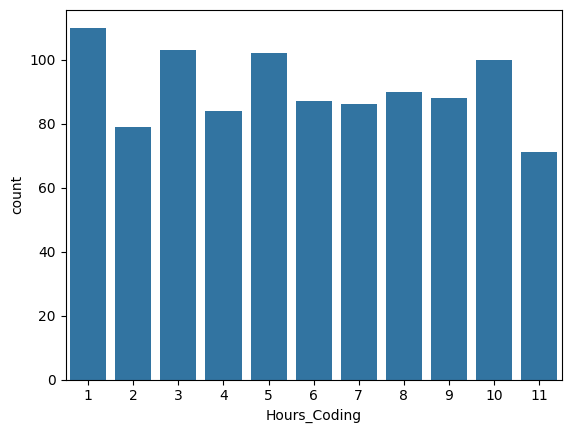

In [49]:
sns.countplot(data=df, x='Hours_Coding')
plt.show()


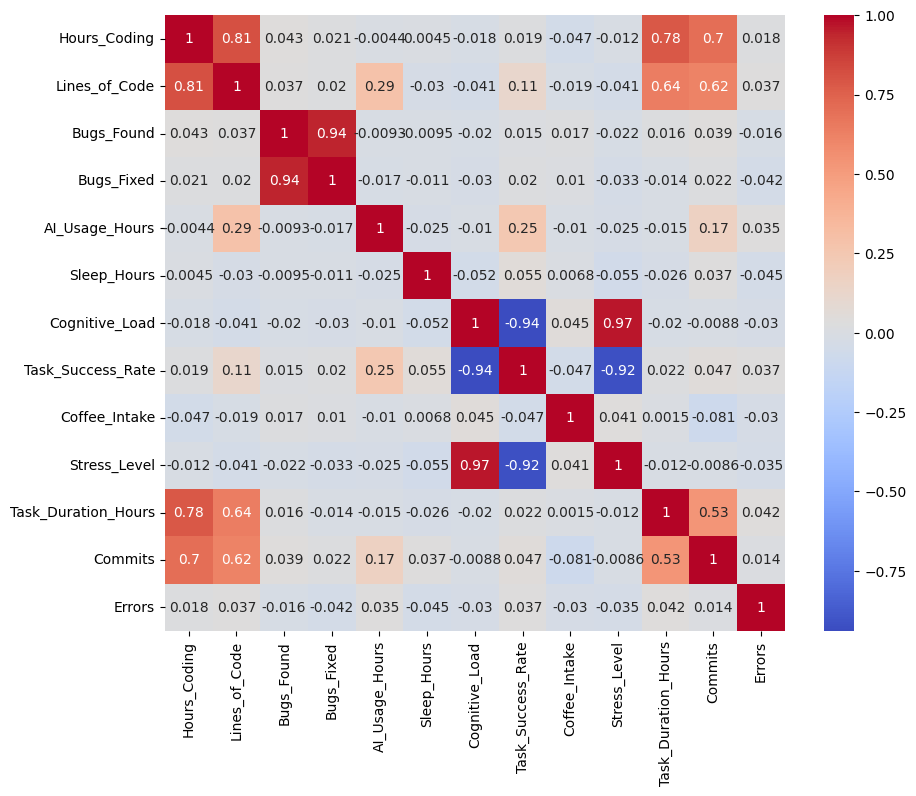

In [30]:
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


R2 Score: 0.9475933475009621
RMSE: 4.607606157214395
Cognitive_Load    0.897460
AI_Usage_Hours    0.053405
Stress_Level      0.020734
Lines_of_Code     0.008660
Sleep_Hours       0.008548
Commits           0.007303
Hours_Coding      0.003890
dtype: float64


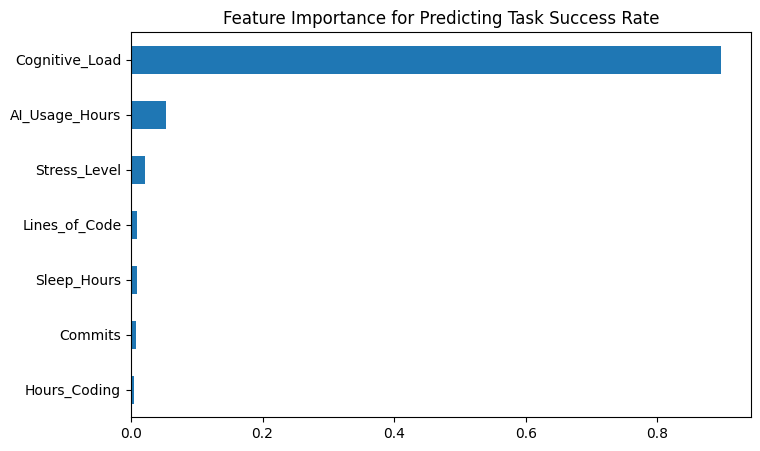

In [33]:
# -------------------------------
# TASK 1: Regression - Predict Task Success Rate
# -------------------------------

features = [
    'Hours_Coding', 'Lines_of_Code', 'AI_Usage_Hours', 'Sleep_Hours',
    'Cognitive_Load', 'Stress_Level', 'Commits'
]

X = df[features]
y = df['Task_Success_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("R2 Score:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

# Feature Importance
importances = pd.Series(model.feature_importances_, index=features)
print(importances.sort_values(ascending=False))

importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title("Feature Importance for Predicting Task Success Rate")
plt.show()


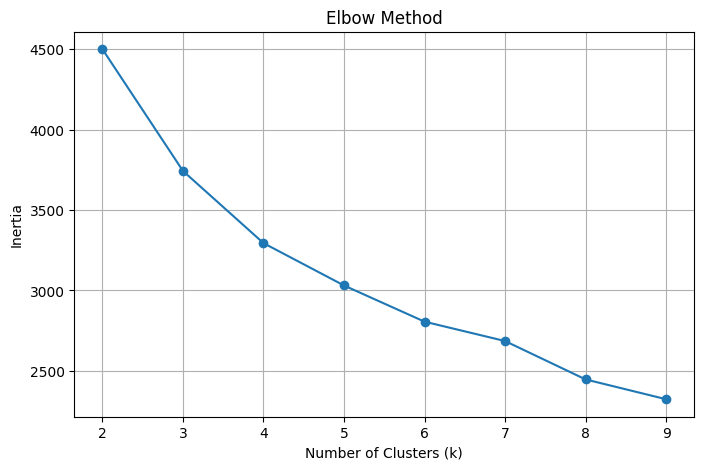

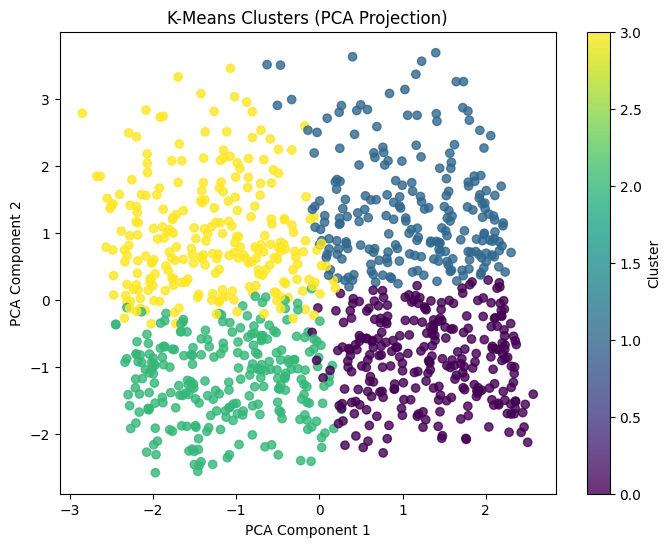


Cluster Behavior Summary:

         Hours_Coding  AI_Usage_Hours  Stress_Level  Cognitive_Load  \
Cluster                                                               
0            3.500000        2.577206     85.136029       75.827206   
1            8.502242        3.367713     85.843049       76.071749   
2            3.209486        2.944664     47.430830       37.984190   
3            8.650794        3.031746     48.055556       38.626984   

           Commits  Sleep_Hours  
Cluster                          
0         9.794118     6.419853  
1        26.282511     6.472646  
2        10.055336     6.427668  
3        24.539683     6.547619  


In [41]:
# -------------------------------
# TASK 2: Clustering - Developer Work Patterns
# -------------------------------

cluster_features = [
    'Hours_Coding', 'AI_Usage_Hours', 'Stress_Level',
    'Cognitive_Load', 'Commits', 'Sleep_Hours'
]

X = df[cluster_features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------
# Elbow Method (k = 2 to 9)
# --------------------------------------
inertia = []
K = range(2, 10)   # Correct range

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# --------------------------------------
# Choose k = 4 based on elbow method
# --------------------------------------
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df["Cluster"] = clusters

# --------------------------------------
# PCA Visualization (2D)
# --------------------------------------
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_vals[:, 0], pca_vals[:, 1], c=clusters, cmap='viridis', alpha=0.8)
plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# --------------------------------------
# Cluster Summary: Interpret behavior patterns
# --------------------------------------
cluster_summary = df.groupby("Cluster")[cluster_features].mean()
print("\nCluster Behavior Summary:\n")
print(cluster_summary)


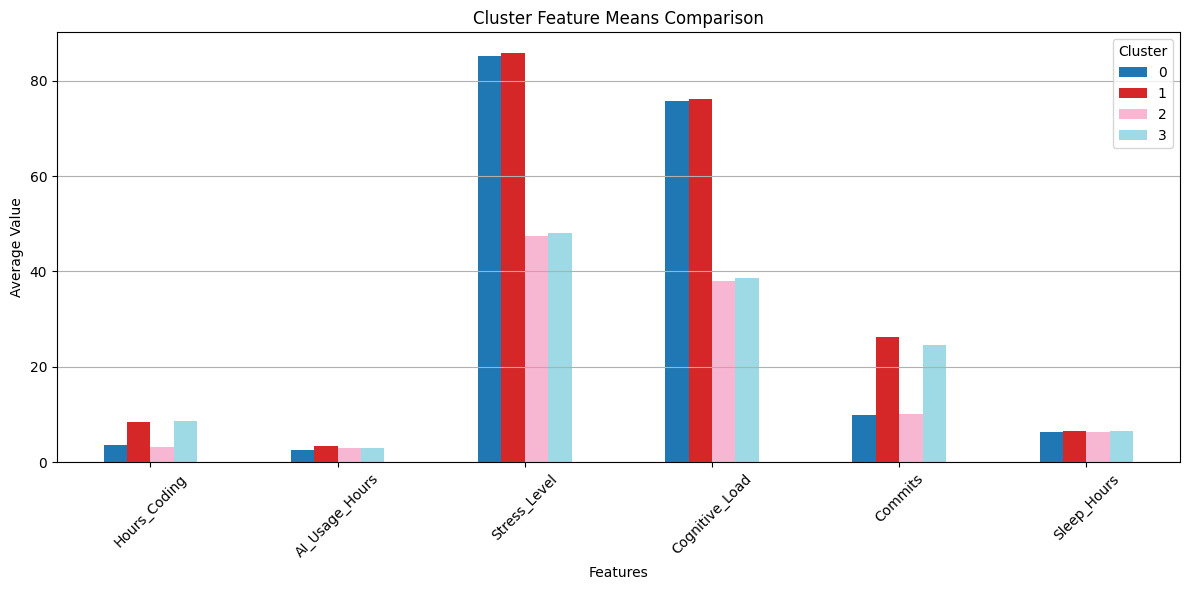

In [42]:
import matplotlib.pyplot as plt

cluster_summary.T.plot(kind='bar', figsize=(12,6), colormap='tab20')
plt.title("Cluster Feature Means Comparison")
plt.xlabel("Features")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


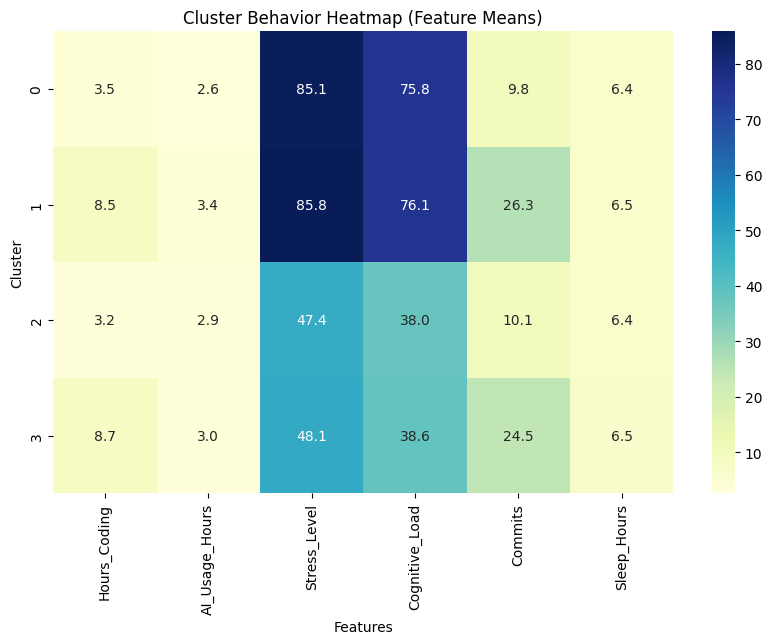

In [43]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cluster Behavior Heatmap (Feature Means)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.show()


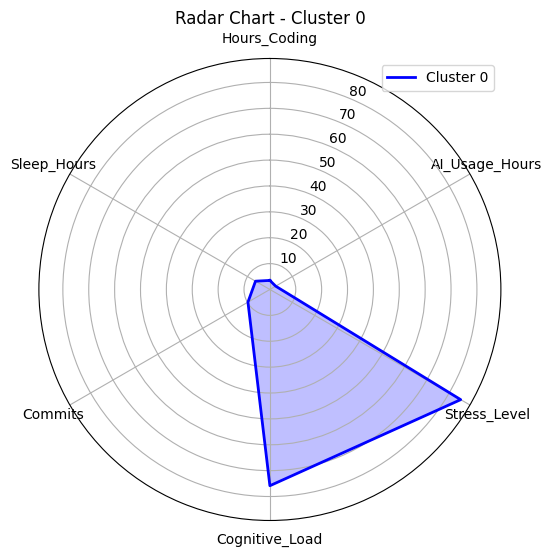

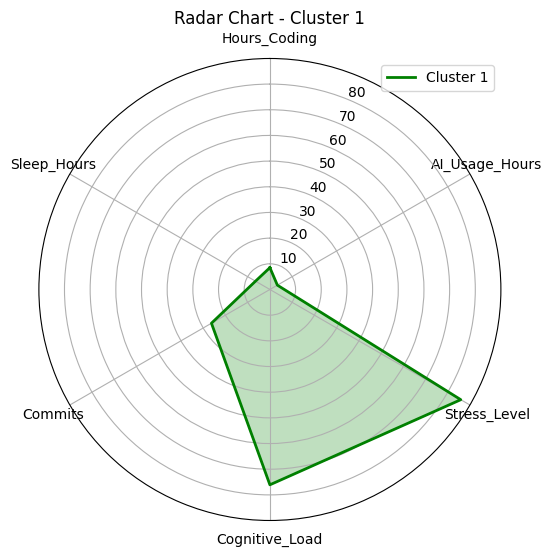

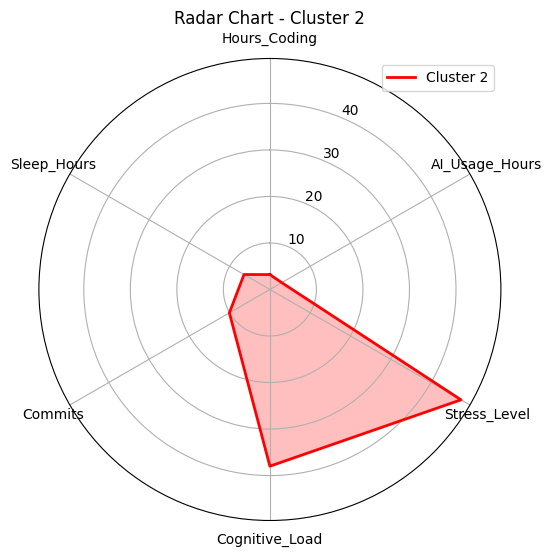

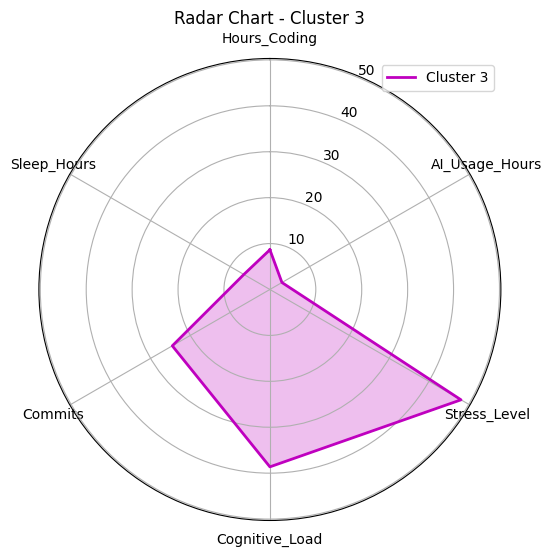

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_separate_radars(df_summary, clusters_to_plot=None):
    labels = df_summary.columns
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # close the circle

    colors = ['b', 'g', 'r', 'm', 'c', 'y']  # Add more colors if needed

    # If no specific clusters given, plot all
    if clusters_to_plot is None:
        clusters_to_plot = df_summary.index.tolist()

    for i, idx in enumerate(clusters_to_plot):
        row = df_summary.loc[idx]
        values = row.tolist()
        values += values[:1]  # close the circle

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        color = colors[i % len(colors)]  # cycle through colors

        ax.plot(angles, values, label=f"Cluster {idx}", color=color, linewidth=2)
        ax.fill(angles, values, alpha=0.25, color=color)

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)

        plt.title(f"Radar Chart - Cluster {idx}")
        plt.legend(loc='upper right')
        plt.show()

# Example usage: Plot radar charts for clusters 0, 1, 2, and 3 separately
plot_separate_radars(cluster_summary, clusters_to_plot=[0, 1, 2, 3])


Correlations with AI_Usage_Hours:
AI_Usage_Hours         1.000000
Lines_of_Code          0.287284
Task_Success_Rate      0.246024
Commits                0.172278
Errors                 0.035324
Hours_Coding          -0.004428
Bugs_Found            -0.009299
Cognitive_Load        -0.010479
Coffee_Intake         -0.010497
Task_Duration_Hours   -0.014990
Bugs_Fixed            -0.017301
Stress_Level          -0.025209
Sleep_Hours           -0.025366
Cluster               -0.139930
Success_Class               NaN
Name: AI_Usage_Hours, dtype: float64


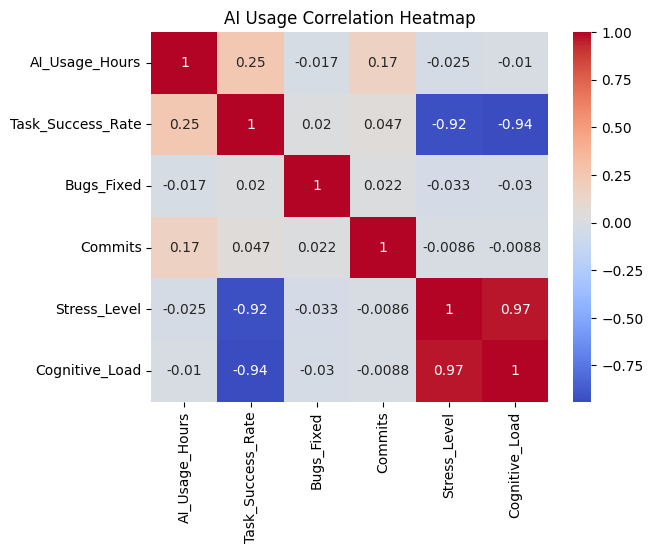

R2 Score: 0.935020352362354
RMSE: 5.130631415268582
          Feature  Coefficient
0  AI_Usage_Hours     2.362464
1    Stress_Level    -0.106189
2  Cognitive_Load    -0.792157
3     Sleep_Hours     0.052670


In [37]:
# -------------------------------
# TASK 6: AI Usage Analysis
# -------------------------------

ai_corrs = df.corr()['AI_Usage_Hours'].sort_values(ascending=False)
print("Correlations with AI_Usage_Hours:")
print(ai_corrs)

ai_targets = ['Task_Success_Rate', 'Bugs_Fixed', 'Commits', 'Stress_Level', 'Cognitive_Load']
df[ai_targets + ['AI_Usage_Hours']].corr()

sns.heatmap(df[['AI_Usage_Hours'] + ai_targets].corr(), annot=True, cmap='coolwarm')
plt.title("AI Usage Correlation Heatmap")
plt.show()

# Regression: does AI usage predict success after controlling for stress/load?
features = ['AI_Usage_Hours', 'Stress_Level', 'Cognitive_Load', 'Sleep_Hours']
X = df[features]
y = df['Task_Success_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("R2 Score:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

coef_table = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
})
print(coef_table)


R2 Score: 0.5136769581114546
RMSE: 4.171629687244542


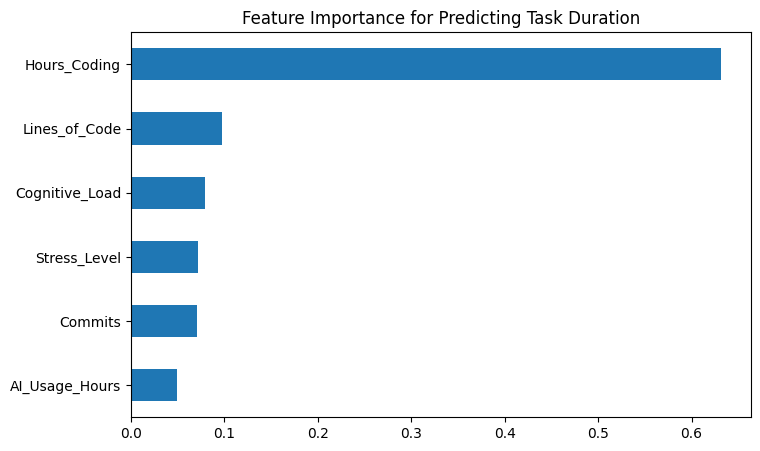

Hours_Coding      0.632010
Lines_of_Code     0.097560
Cognitive_Load    0.079335
Stress_Level      0.072041
Commits           0.070179
AI_Usage_Hours    0.048876
dtype: float64


In [39]:
# -------------------------------
# TASK 9: Regression - Predict Task Duration
# -------------------------------

features = [
    'Hours_Coding', 'Lines_of_Code', 'Commits',
    'Cognitive_Load', 'Stress_Level', 'AI_Usage_Hours'
]

X = df[features]
y = df['Task_Duration_Hours']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("R2 Score:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

# Feature importance
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance for Predicting Task Duration")
plt.show()

print(importances.sort_values(ascending=False))
